# Machine Learning Zoomcamp Midterm Project
---
## German Credit Risk Evaluation

- Dataset: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix

import matplotlib as mpl

# definition of notebook figures patterns 

sns.set_style("white")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("pastel")

In [36]:
# functions 

def bar_plot(df: pd.DataFrame, column: str, title: str, x_label: str, ax=None) -> None:
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 4))
    df_ = df.groupby(column)['risk'].value_counts(normalize=True).rename('prop').reset_index()
    df_.prop = np.round(df_.prop * 100, 2)
    sns.barplot(data=df_, x=column, y='prop', hue='risk', ax=ax)
    ax.legend(title="Credit Risk")
    for value in ax.containers:
        ax.bar_label(value, label_type='edge', fontsize=9, family='monospace')
    ax.set_xlabel(x_label, fontsize='large', family='monospace')
    ax.set_ylabel('Proportion', fontsize='large', family='monospace')
    ax.set_title(title, fontsize='large', fontweight='bold', style='italic', family='monospace')

def histogram_plot(df: pd.DataFrame, column: str, title: str, bins: int) -> None:
    _, ax = plt.subplots(figsize=(20, 8))
    sns.histplot(data=df, x=column, ax=ax, hue='risk', bins=bins, kde=True, alpha=.75)
    ax.legend(title="Credit Risk", loc="upper right", labels=["Bad", "Good"])
    for value in ax.containers:
        ax.bar_label(value, label_type='edge', fontsize=9, family='monospace')
    ax.set_xlabel(None)
    ax.set_ylabel('Count', fontsize='large', family='monospace')
    ax.set_title(title, fontsize='large', fontweight='bold', style='italic', family='monospace')

def split_data(df):
    train, test = train_test_split(df, test_size=0.4, random_state=42)
    test, val = train_test_split(test, test_size=0.5, random_state=42)
    return train, test, val

def run_model_cv(df, model_type):
    X = pd.get_dummies(df.drop('risk', axis=1))
    y = df['risk']
    
    if model_type == 1:
        model = LogisticRegression(max_iter=1000, random_state=42)
        model_name = 'Logistic Regression'
    elif model_type == 2:
        model = KNeighborsClassifier()
        model_name = 'KNN Classifier'
    elif model_type == 3:
        model = RandomForestClassifier(random_state=42)
        model_name = 'Random Forest Classifier'
    elif model_type == 4:
        model = [LogisticRegression(max_iter=1000), KNeighborsClassifier(), RandomForestClassifier()]
        model_name = ['Logistic Regression', 'KNN Classifier', 'Random Forest Classifier']
    else:
        raise ValueError("Invalid model type. Please choose 1 for Logistic Regression, 2 for KNN Classifier, 3 for Random Forest Classifier, or 4 for all models.")
    
    if isinstance(model, list):
        scores_recall = []
        scores_roc_auc = []
        for i, m in enumerate(model):
            recall_score = cross_val_score(m, X, y, cv=5, scoring='recall').mean()
            roc_auc_score = cross_val_score(m, X, y, cv=5, scoring='roc_auc').mean()
            scores_recall.append(recall_score)
            scores_roc_auc.append(roc_auc_score)
        results = pd.DataFrame({'Recall': scores_recall, 'ROC AUC': scores_roc_auc}, index=model_name)
    else:
        recall_score = cross_val_score(model, X, y, cv=5, scoring='recall').mean()
        roc_auc_score = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()
        results = pd.DataFrame({'Recall': [recall_score], 'ROC AUC': [roc_auc_score]}, index=[model_name])
    
    return results

def balance_dataset(df: pd.DataFrame, target: str, percentual=.45) -> pd.DataFrame:
    df_balanced = df.copy()
    while True:
        majority, minority = df_balanced[target].value_counts(normalize=True).index.to_list()
        
        if np.random.randint(2): # Maioria
            idx = df_balanced[df_balanced[target] == majority].sample(1).index
            df_balanced.drop(index=idx, inplace=True)
            df_balanced.reset_index(drop=True, inplace=True)
        else: # Minoria
            idx = df[df[target] == minority].sample(1).index
            df_balanced = pd.concat([df_balanced, df.iloc[idx, :]], ignore_index=True)
        
        if percentual-.05 < df_balanced[target].value_counts(normalize=True).values[1] <= percentual+.05:
            break
        
    return df_balanced

# Exploratory Data Analysis (EDA)

In [37]:
# columns provided from the dataset description 
columns = ['status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings', 'employment_since', 'installment_rate', 'personal_status_and_sex', 'others_debtors_guarantors', 'residence_since', 'property', 'age', 'installment_plans', 'housing', 'existing_credits', 'job', 'people_maitenance', 'telephone', 'foreign_worker', 'risk']

# read the dataset

df = pd.read_csv('german.data', sep='\s+', header=None, names=columns)
df.head()

,status,duration,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,personal_status_and_sex,others_debtors_guarantors,...,property,age,installment_plans,housing,existing_credits,job,people_maitenance,telephone,foreign_worker,risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [38]:
# overview of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   status                     1000 non-null   object
 1   duration                   1000 non-null   int64 
 2   credit_history             1000 non-null   object
 3   purpose                    1000 non-null   object
 4   credit_amount              1000 non-null   int64 
 5   savings                    1000 non-null   object
 6   employment_since           1000 non-null   object
 7   installment_rate           1000 non-null   int64 
 8   personal_status_and_sex    1000 non-null   object
 9   others_debtors_guarantors  1000 non-null   object
 10  residence_since            1000 non-null   int64 
 11  property                   1000 non-null   object
 12  age                        1000 non-null   int64 
 13  installment_plans          1000 non-null   object
 14  housing  

- The dataset has a total of 1000 entries and 21 variables. It has no missing data or duplicate data. Most of the variables are categorical and represent personal data about users such as financial and social aspects.

In [39]:
# adjusting target variable values

df['risk'] = df['risk'].apply(lambda x: 0 if x == 1 else 1 if x == 2 else x)

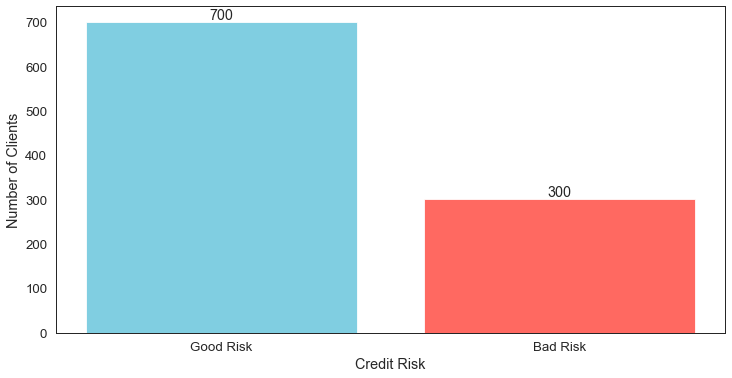

In [40]:
plt.figure(figsize=(12, 6))

plt.bar(df['risk'].value_counts().index, df['risk'].value_counts().values, color=['#80CEE1', '#FF6961'])
plt.xlabel('Credit Risk')
plt.ylabel('Number of Clients')

for i, v in enumerate(df['risk'].value_counts().values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.xticks([0, 1], ['Good Risk', 'Bad Risk'])
plt.show()

- 70% of users have good credit risk; 
- There is an imbalance in the data that will be evaluated later.

In [41]:
# adjusting categorical variables

df['installment_rate'] = df['installment_rate'].astype('category')
df['residence_since'] = df['residence_since'].astype('category')
df['existing_credits'] = df['existing_credits'].astype('category')
df['people_maitenance'] = df['people_maitenance'].astype('category')

purpose_pct = df['purpose'].value_counts(normalize=True)

categories_to_replace = purpose_pct[purpose_pct <= 0.05].index.tolist()

df.loc[df['purpose'].isin(categories_to_replace), 'purpose'] = 'others'

####  Then, analyzes were carried out involving the categorical variables of the data set and the relationship with the target variable ("risk").

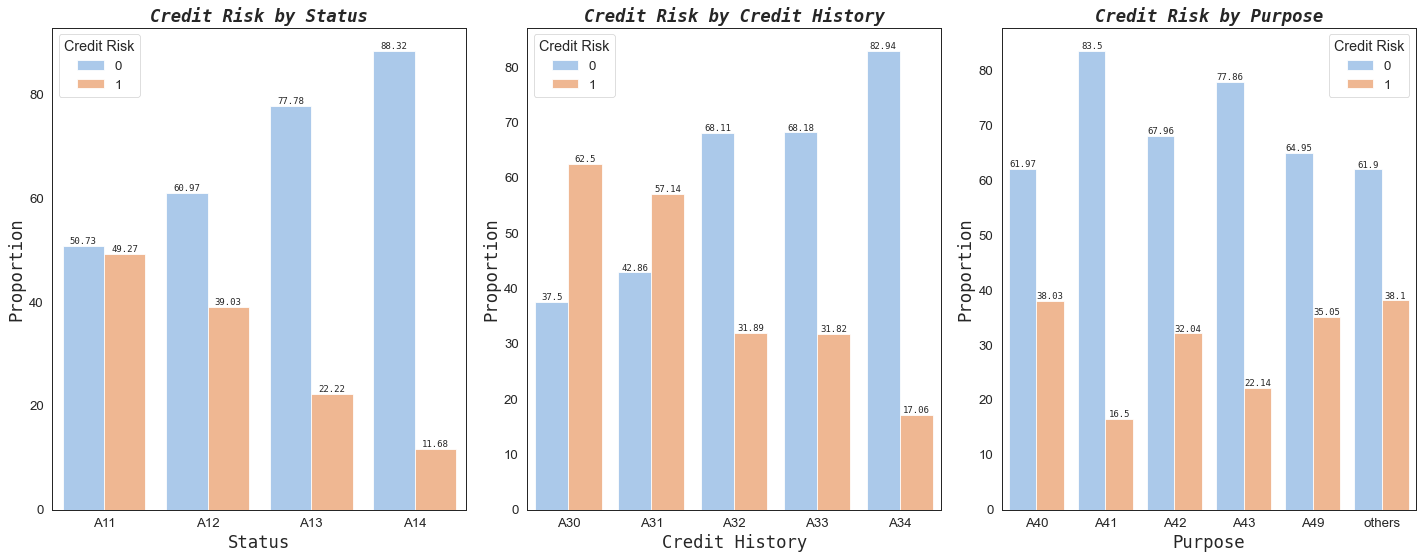

In [42]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 8))

bar_plot(df, 'status', 'Credit Risk by Status', 'Status', ax=axs[0])
bar_plot(df, 'credit_history', 'Credit Risk by Credit History', 'Credit History', ax=axs[1])
bar_plot(df, 'purpose', 'Credit Risk by Purpose', 'Purpose', ax=axs[2])

plt.tight_layout()
plt.show()

####  As expected, most people with a high risk of obtaining credit are those who have little savings in their bank accounts and also those who have already taken out loans. As for the reason for asking for a loan, there are a variety of associated reasons, however, among the most common, those that offer less risk are loans for purchasing used cars and for radio/television. This may be related to the loan amount itself, which tends to be lower than loans for new cars and business investments.

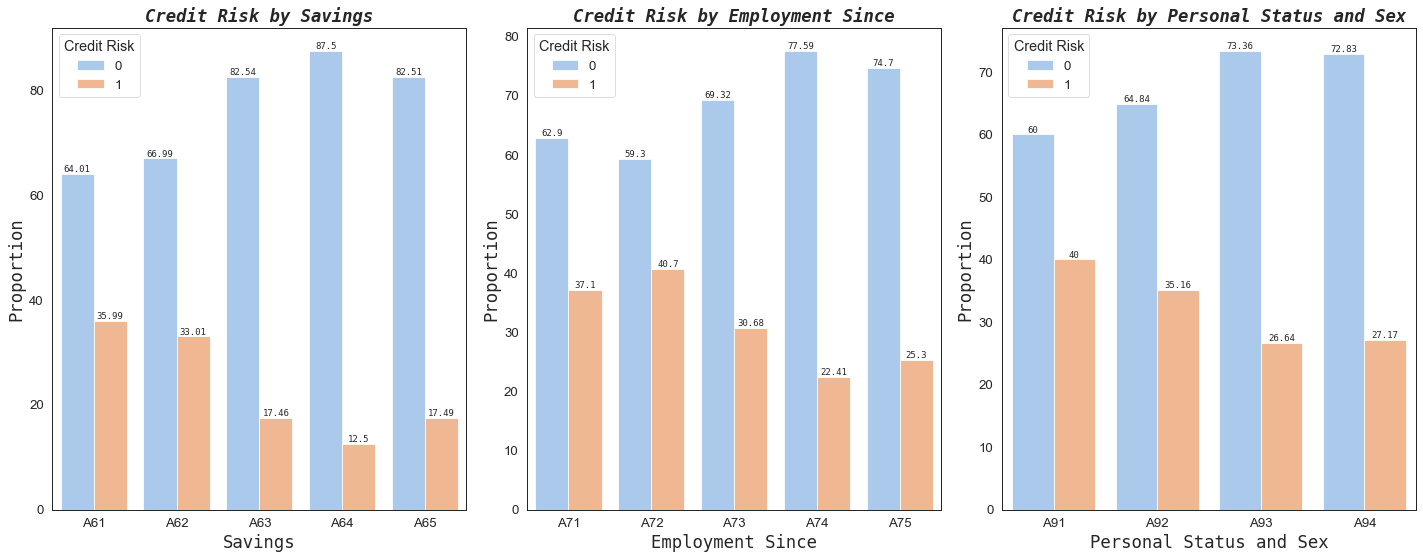

In [43]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 8))

bar_plot(df, 'savings', 'Credit Risk by Savings', 'Savings', ax=axs[0])
bar_plot(df, 'employment_since', 'Credit Risk by Employment Since', 'Employment Since', ax=axs[1])
bar_plot(df, 'personal_status_and_sex', 'Credit Risk by Personal Status and Sex', 'Personal Status and Sex', ax=axs[2])

plt.tight_layout()
plt.show()

#### Next, analyzing the graphs above, the greatest risks are observed in people who do not have a large income in savings and unemployed or recently employed people. Furthermore, it is clear that divorced or separated men and women are the most likely to have a high risk of defaulting on loans.

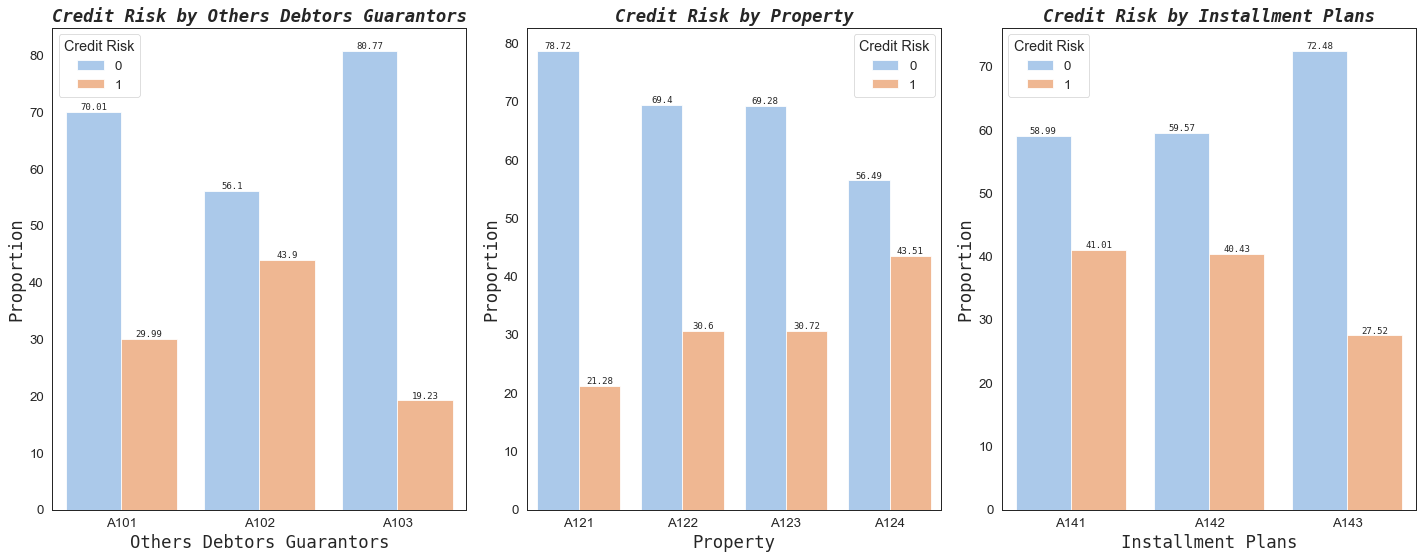

In [44]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 8))

bar_plot(df, 'others_debtors_guarantors', 'Credit Risk by Others Debtors Guarantors', 'Others Debtors Guarantors', ax=axs[0])
bar_plot(df, 'property', 'Credit Risk by Property', 'Property', ax=axs[1])
bar_plot(df, 'installment_plans', 'Credit Risk by Installment Plans', 'Installment Plans', ax=axs[2])

plt.tight_layout()
plt.show()

#### The main actors in this process are life insurance companies, car companies and civil society savings agreements. Installment plans do not appear to have a major influence on credit risk.

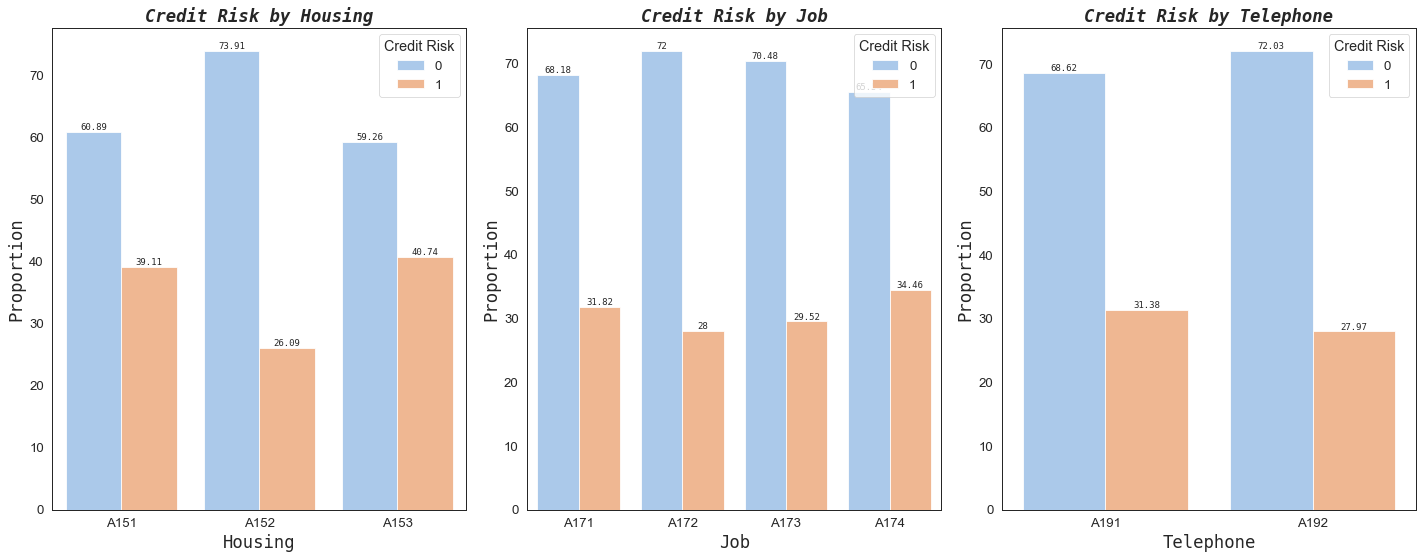

In [45]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 8))

bar_plot(df, 'housing', 'Credit Risk by Housing', 'Housing', ax=axs[0])
bar_plot(df, 'job', 'Credit Risk by Job', 'Job', ax=axs[1])
bar_plot(df, 'telephone', 'Credit Risk by Telephone', 'Telephone', ax=axs[2])

plt.tight_layout()
plt.show()

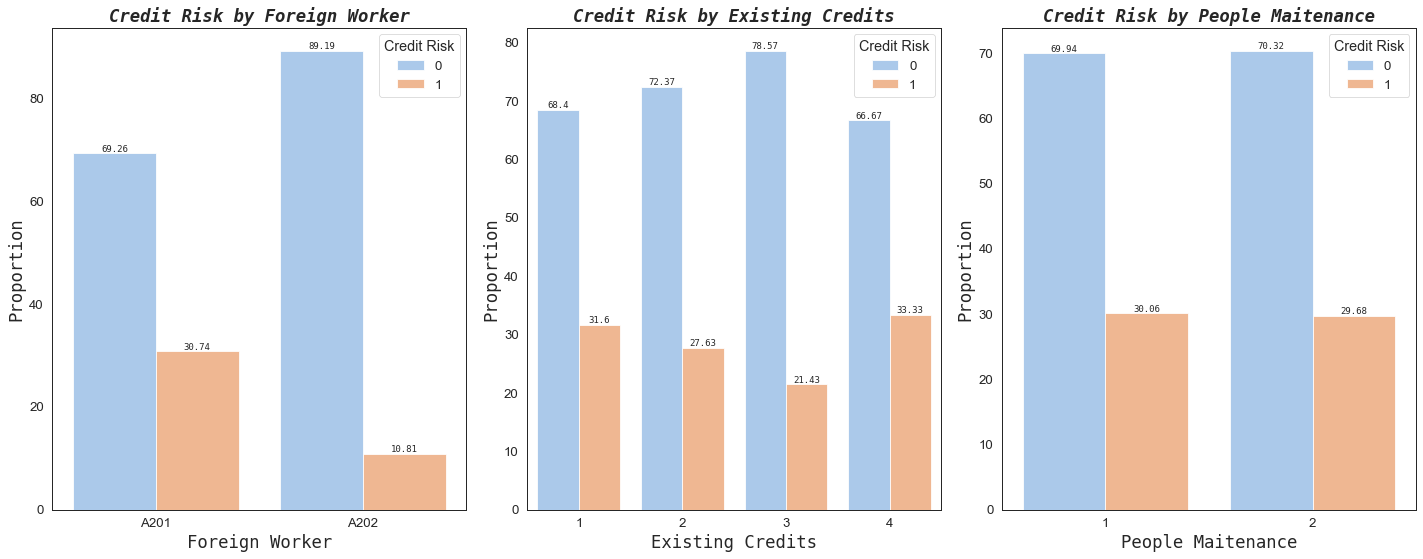

In [46]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 8))

bar_plot(df, 'foreign_worker', 'Credit Risk by Foreign Worker', 'Foreign Worker', ax=axs[0])
bar_plot(df, 'existing_credits', 'Credit Risk by Existing Credits', 'Existing Credits', ax=axs[1])
bar_plot(df, 'people_maitenance', 'Credit Risk by People Maitenance', 'People Maitenance', ax=axs[2])

plt.tight_layout()
plt.show()

#### Being a foreigner is a risk factor of almost three times compared to non-foreigners.

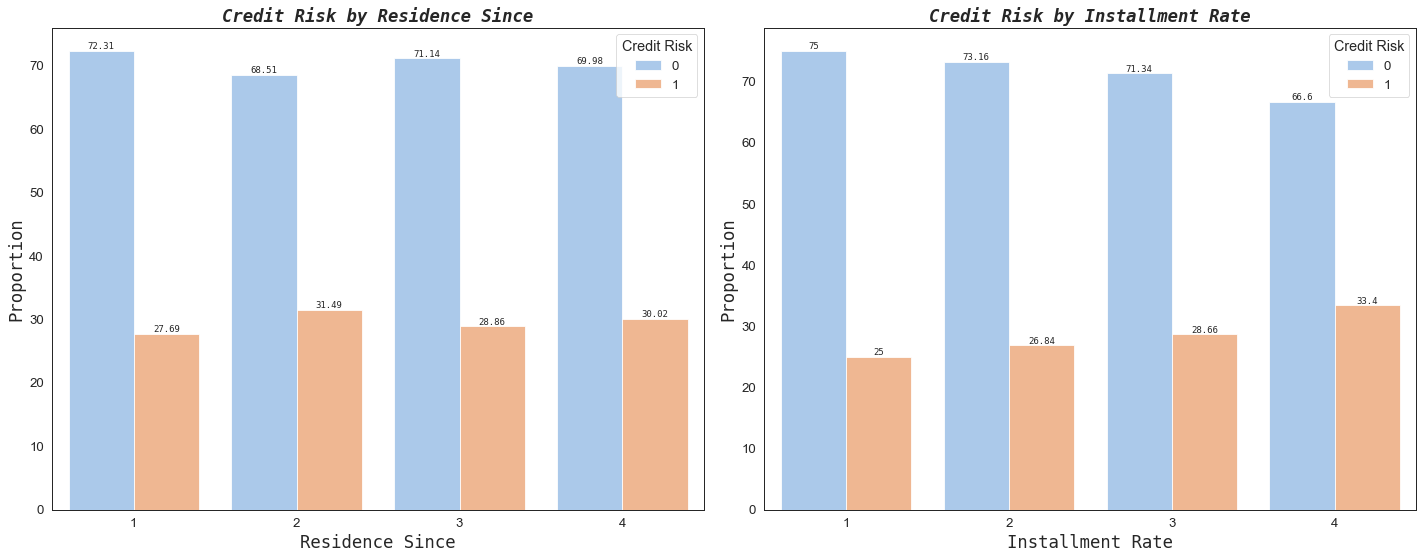

In [47]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

bar_plot(df, 'residence_since', 'Credit Risk by Residence Since', 'Residence Since', ax=axs[0])
bar_plot(df, 'installment_rate', 'Credit Risk by Installment Rate', 'Installment Rate', ax=axs[1])

plt.tight_layout()
plt.show()

#### Then, there are the evaluations of the numerical variables where it is clear that the average loan duration is 20 months, the average age of people who ask for a loan is around 36 years old and the average loan amount taken by these people is 3270 euros. In the graphical analysis, it can be seen that the vast majority of loans were made to people aged between 20 and 40 and the vast majority of loans were in the range of 1500 euros.

In [48]:
# overview of the numerical variables

df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
credit_amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
risk,1000.0,0.300,0.458487,0.0,0.0,0.0,1.00,1.0


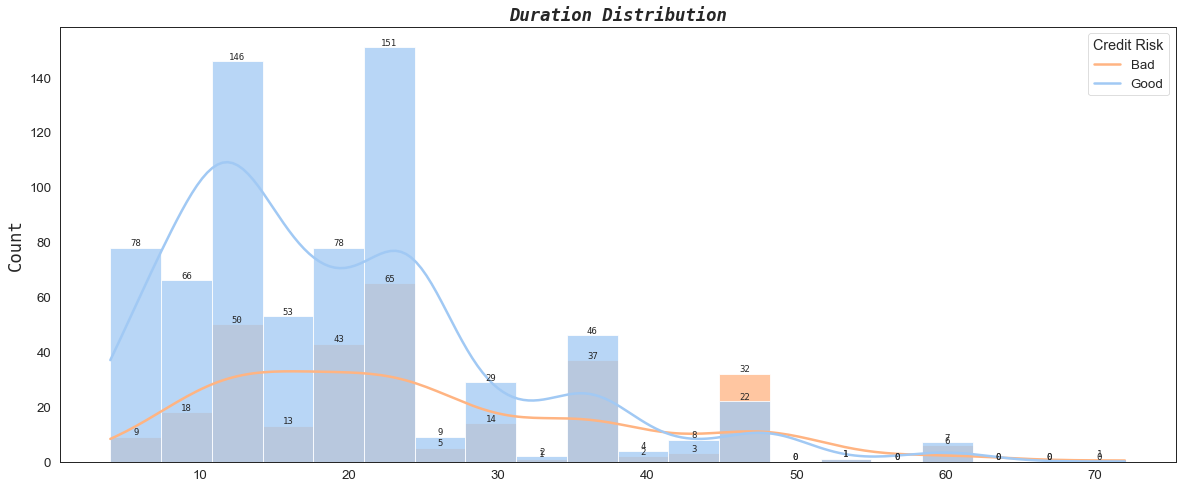

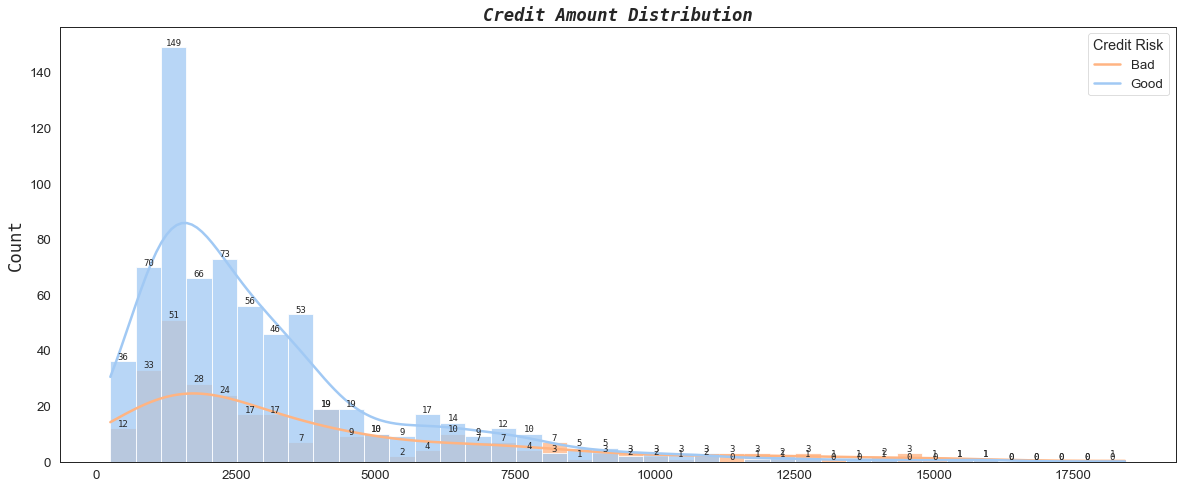

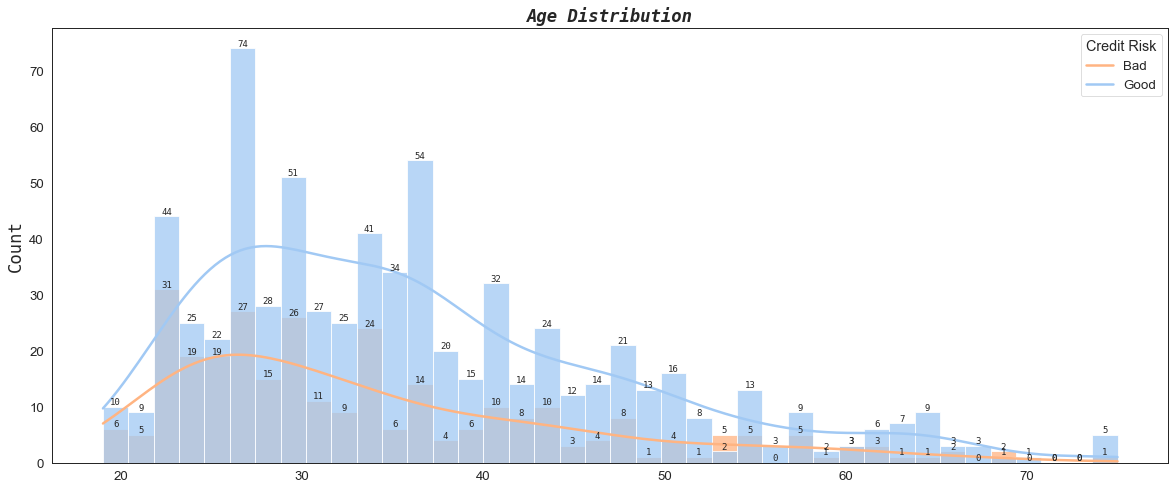

In [49]:
# graphical overview of the numerical variables

histogram_plot(df, 'duration', 'Duration Distribution', 20)
histogram_plot(df, 'credit_amount', 'Credit Amount Distribution', 40)
histogram_plot(df, 'age', 'Age Distribution', 40)

plt.show()

# Model Training

### For model training, 3 models were evaluated that use different methods to classify the data.
#### Logistic regression, KNN and Random Forest Classifier. 
- The main metric for analyzing the models' performance was **Recall**, as we chose to minimize false negatives, as it would be more damaging to have a "good credit" prediction for a user with a high credit risk.

In [50]:
# pipeline for model training
object_cols = df.select_dtypes(include=['object']).columns.tolist()

In [51]:
# Run the function for all models
results = run_model_cv(df, 4)

# Print the results
print(results)

                            Recall   ROC AUC
Logistic Regression       0.463333  0.784714
KNN Classifier            0.216667  0.554512
Random Forest Classifier  0.363333  0.786548


# Feature Importance

In [52]:
# importance of features for logistic regression model

# Split the data into train, test, and validation sets
train, test, val = split_data(df)

# One-hot encode the categorical variables
train = pd.get_dummies(train, columns=object_cols)
test = pd.get_dummies(test, columns=object_cols)
val = pd.get_dummies(val, columns=object_cols)

# Fit the logistic regression model
X_train = train.drop('risk', axis=1)
y_train = train['risk']
X_test = test.drop('risk', axis=1)
y_test = test['risk']
X_val = val.drop('risk', axis=1)
y_val = val['risk']

lr = LogisticRegression(max_iter=1000, random_state=42) 
lr.fit(X_train, y_train)

# Get the coefficients for each feature
coefs = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr.coef_[0]})
coefs['Coefficient'] = (coefs['Coefficient'] * 100).round(2)
coefs['Abs_Coefficient'] = coefs['Coefficient'].abs()

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate the ROC AUC and recall scores
roc_auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Logististic Regression Model')
print('')
print('ROC AUC:', round(roc_auc,2))
print('Recall:', round(recall,2))
print('')

# Sort the coefficients by absolute value
coefs = coefs.sort_values(by='Abs_Coefficient', ascending=False)

# Print the top 10 most important features
print(coefs.head(10))
coefs['Abs_Coefficient'] = coefs['Coefficient'].abs()


Logististic Regression Model

ROC AUC: 0.63
Recall: 0.43

                   Feature  Coefficient  Abs_Coefficient
15      credit_history_A34       -89.38            89.38
17             purpose_A41       -81.66            81.66
10              status_A14       -75.99            75.99
16             purpose_A40        70.59            70.59
26             savings_A65       -61.43            61.43
45  installment_plans_A143       -57.74            57.74
39           property_A121       -56.50            56.50
47            housing_A152       -52.36            52.36
54          telephone_A192       -48.53            48.53
7               status_A11        46.89            46.89


#### The most important variables for the model were:
- (A34) Account in critical condition and committed to other credits;
- (A41) Loan to pay off used cars;
- (A14) People without a current account;
- (A40) Loan for purchasing new cars;
- (A65) people without a savings account.

# Hyperparameters Tuning

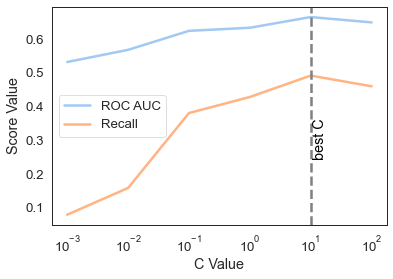

In [53]:
# hyperparameter tuning for logistic regression model

# Define a list of regularization values to test
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Initialize empty lists to store roc_auc and recall values
roc_auc_values = []
recall_values = []

# Fit the logistic regression model with different regularization values
for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lr.predict(X_test)

    # Calculate the ROC AUC and recall scores
    roc_auc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Append the roc_auc and recall values to the corresponding lists
    roc_auc_values.append(roc_auc)
    recall_values.append(recall)

# Plot the roc_auc and recall values as a function of C
plt.figsize=(12, 8)
plt.plot(C_values, roc_auc_values, label='ROC AUC')
plt.plot(C_values, recall_values, label='Recall')
plt.xscale('log')
plt.xlabel('C Value')
plt.ylabel('Score Value')
plt.legend()

# Add a vertical dashed line at C=10 with the text "best C"
plt.axvline(x=10, linestyle='--', color='gray')
plt.text(11, 0.25, 'best C', rotation=90, color='black')
plt.show()

In [54]:
# Fit the logistic regression model with the best C value
lr = LogisticRegression(C=10, max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Make predictions on the train, test, and validation sets
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
y_val_pred = lr.predict(X_val)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
val_recall = recall_score(y_val, y_val_pred)

train_roc_auc = roc_auc_score(y_train, y_train_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred)

# Create a dataframe with the metric values for the train, test, and validation sets
results_df = pd.DataFrame({'Metric': ['Recall', 'ROC AUC'],
                           'Train': [train_recall, train_roc_auc],
                           'Test': [test_recall, test_roc_auc],
                           'Validation': [val_recall, val_roc_auc]})

# Print the dataframe
print(results_df)

    Metric     Train      Test  Validation
0   Recall  0.538462  0.492063    0.490909
1  ROC AUC  0.722580  0.665740    0.700627


# Dataset balancing 

#### To improve the model's performance, a set of techniques was used to increase the number of entities with bad credit risk and reduce the number of entities with good credit risk. This was done in order to minimize the risks of model bias.

In [59]:
df_balanced = balance_dataset(df, 'risk', percentual=.5)
df_balanced.risk.value_counts(normalize=True)

0    0.549603
1    0.450397
Name: risk, dtype: float64

In [60]:
# Split the data into train, test, and validation sets
train, test, val = split_data(df_balanced)

# One-hot encode the categorical variables
train = pd.get_dummies(train, columns=object_cols)
test = pd.get_dummies(test, columns=object_cols)
val = pd.get_dummies(val, columns=object_cols)

# Split the data into X and y
X_train = train.drop('risk', axis=1)
y_train = train['risk']
X_test = test.drop('risk', axis=1)
y_test = test['risk']

# Fit the logistic regression model
lr = LogisticRegression(C=10, max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate the ROC AUC and recall scores
roc_auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the scores
print('Logistic Regression Model')
print('')
print('ROC AUC:', round(roc_auc,2))
print('Recall:', round(recall,2))

Logistic Regression Model

ROC AUC: 0.66
Recall: 0.63


In [61]:

# Split the data into X and y (train)
X_train = train.drop('risk', axis=1)
y_train = train['risk']

# split the data into X and y (test)

X_test = test.drop('risk', axis=1)
y_test = test['risk']

# Split the data into X and y (validation)
X_val = val.drop('risk', axis=1)
y_val = val['risk']

# Make predictions on the train set
y_pred_train = lr.predict(X_train)

# Calculate the ROC AUC and recall scores for train set
roc_auc_train = roc_auc_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)

# Print the scores for train set
print('Train Set')
print('ROC AUC:', round(roc_auc_train,2))
print('Recall:', round(recall_train,2))
print('')

# Make predictions on the test set
y_pred_test = lr.predict(X_test)

# Calculate the ROC AUC and recall scores for test set
roc_auc_test = roc_auc_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)

# Print the scores for test set
print('Test Set')
print('ROC AUC:', round(roc_auc_test,2))
print('Recall:', round(recall_test,2))
print('')

# Make predictions on the validation set
y_pred_val = lr.predict(X_val)

# Calculate the ROC AUC and recall scores for validation set
roc_auc_val = roc_auc_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)

# Print the scores for validation set
print('Validation Set')
print('ROC AUC:', round(roc_auc_val,2))
print('Recall:', round(recall_val,2))

Train Set
ROC AUC: 0.8
Recall: 0.79

Test Set
ROC AUC: 0.66
Recall: 0.63

Validation Set
ROC AUC: 0.71
Recall: 0.65


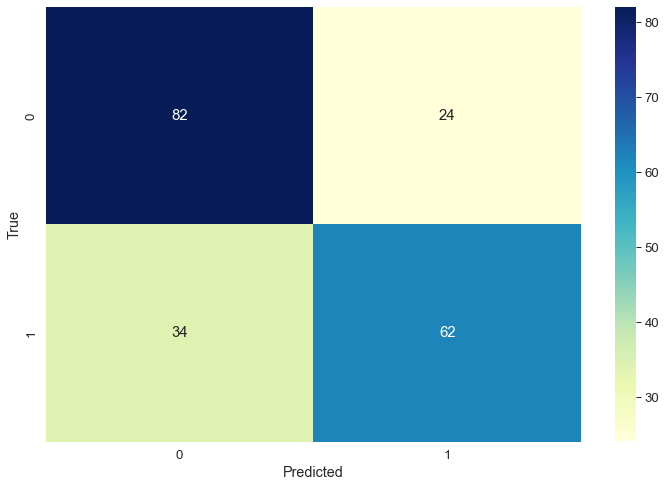

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation set
y_pred_val = lr.predict(X_val)

# Create the confusion matrix
cm = confusion_matrix(y_val, y_pred_val)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='g', ax=ax, annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Conclusions

It was possible to build a simple logistic regression model with **Recall 0.65** capable of identifying users with high credit risk.